In [1]:
import requests
import matplotlib.pyplot as plt
import csv
from concurrent.futures import ThreadPoolExecutor, as_completed

API keys can be found here: https://twelvedata.com/account/api-keys

In [2]:
# Function to read API key from CSV
def get_api_key(file_path, service_name):
    with open(file_path, 'r') as csvfile:
        reader = csv.DictReader(csvfile)
        for row in reader:
            if row['service'] == service_name:
                return row['key']
    raise ValueError(f"API key for {service_name} not found in the CSV file")

In [4]:

# Twelve Data API endpoint
BASE_URL = "https://api.twelvedata.com/statistics"

# Get API key from CSV file
API_KEY = get_api_key('api_keys.csv', 'twelve_data')

# List of stock symbols (replace with your list of up to 100 stocks) 
symbols = ["AAPL", "GOOGL", "MSFT", "AMZN", "FB"]


Response for AMZN:
{'code': 403, 'message': '/statistics is available exclusively with pro or enterprise plans. Consider upgrading your API Key now at https://twelvedata.com/pricing', 'status': 'error'}

Response for GOOGL:
{'code': 403, 'message': '/statistics is available exclusively with pro or enterprise plans. Consider upgrading your API Key now at https://twelvedata.com/pricing', 'status': 'error'}

Response for MSFT:
{'code': 403, 'message': '/statistics is available exclusively with pro or enterprise plans. Consider upgrading your API Key now at https://twelvedata.com/pricing', 'status': 'error'}

Response for FB:
{'code': 403, 'message': '/statistics is available exclusively with pro or enterprise plans. Consider upgrading your API Key now at https://twelvedata.com/pricing', 'status': 'error'}

Response for AAPL:
{'meta': {'symbol': 'AAPL', 'name': 'Apple Inc', 'currency': 'USD', 'exchange': 'NASDAQ', 'mic_code': 'XNGS', 'exchange_timezone': 'America/New_York'}, 'statistics':

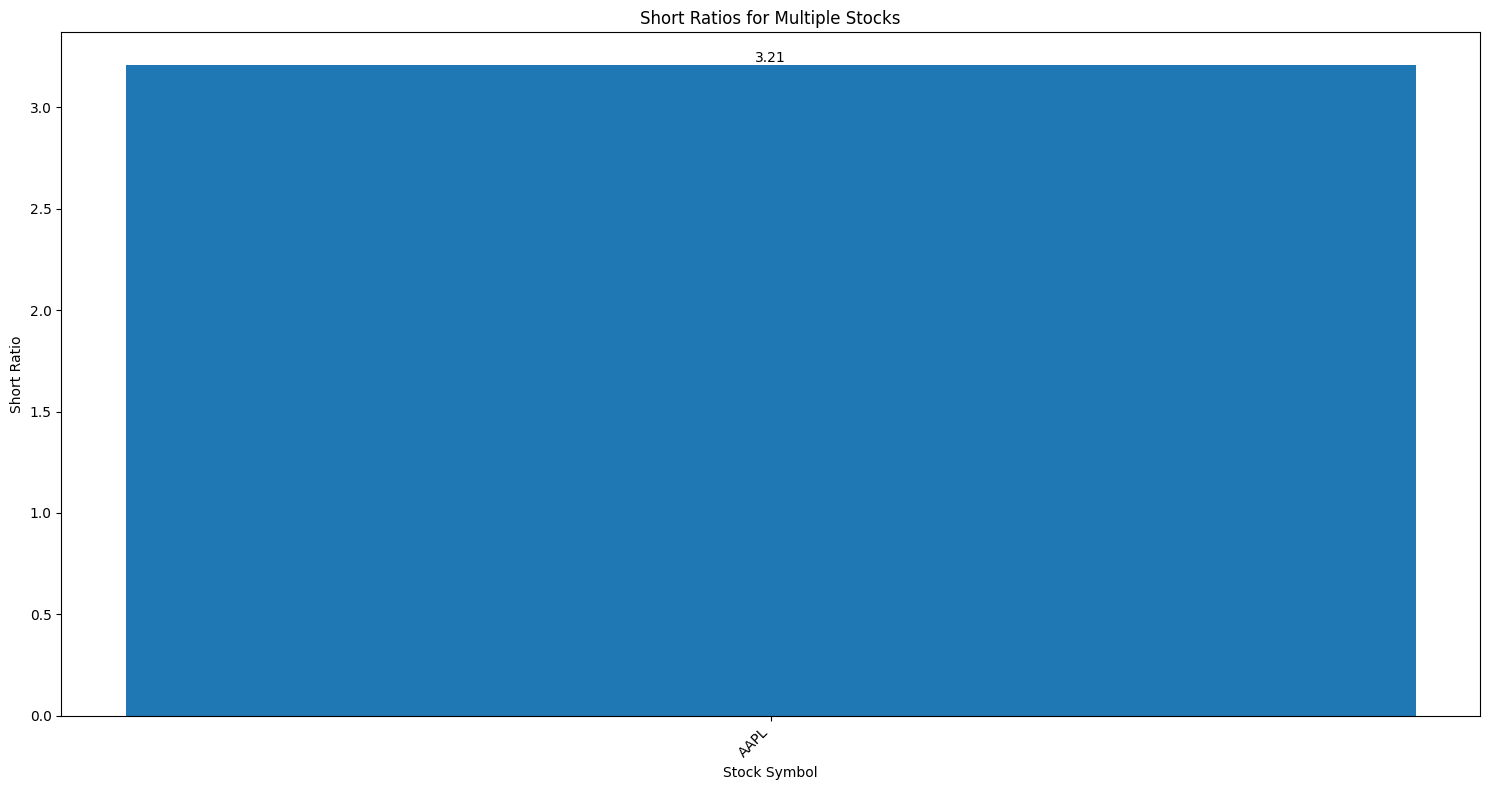


Short Ratios:
Apple Inc (AAPL): 3.21


In [5]:


def get_short_ratio(symbol):
    try:
        params = {
            "symbol": symbol,
            "apikey": API_KEY
        }
        response = requests.get(BASE_URL, params=params)
        response.raise_for_status()
        
        print(f"\nResponse for {symbol}:")
        print(response.json())
        
        data = response.json()
        if "statistics" in data and "stock_statistics" in data["statistics"]:
            short_ratio = float(data["statistics"]["stock_statistics"]["short_ratio"])
            company_name = data["meta"]["name"]
            return symbol, company_name, short_ratio
    except Exception as e:
        print(f"Error fetching data for {symbol}: {e}")
    
    return symbol, None, None

# Fetch data for all symbols
results = []
with ThreadPoolExecutor(max_workers=5) as executor:
    future_to_symbol = {executor.submit(get_short_ratio, symbol): symbol for symbol in symbols}
    for future in as_completed(future_to_symbol):
        results.append(future.result())

print("\nRaw results:")
for result in results:
    print(result)

# Filter out None results and sort by short ratio
valid_results = [r for r in results if r[1] is not None]
print(f"\nNumber of valid results: {len(valid_results)}")

valid_results.sort(key=lambda x: x[2], reverse=True)

# Prepare data for plotting
symbols_to_plot = [r[0] for r in valid_results]
short_ratios = [r[2] for r in valid_results]

# Plotting
plt.figure(figsize=(15, 8))
bars = plt.bar(symbols_to_plot, short_ratios)
plt.title('Short Ratios for Multiple Stocks')
plt.xlabel('Stock Symbol')
plt.ylabel('Short Ratio')
plt.xticks(rotation=45, ha='right')

# Add value labels on top of the bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.2f}',
             ha='center', va='bottom')

plt.tight_layout()
plt.show()

# Print results
print("\nShort Ratios:")
for symbol, company_name, short_ratio in valid_results: 
    print(f"{company_name} ({symbol}): {short_ratio:.2f}")